In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
#from plot_keras_history import plot_history

# Prepocessing

In [2]:
print("Load MNIST data set:")
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

print()
print("Encode y data:") 
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))
print()
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)


print()
print('Min-Max Normalization:')
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255
print(set(x_train_norm[0]))

Load MNIST data set:
x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)

Encode y data:
First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)
x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)

Min-Max Normalization:
{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.4

# EXPERIMENT 1: 
Our dense neural network will consist of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits). We use mnist.load_data() to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 activation values of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a boxplot. We expect the overlap between the range of values in the "boxes" to be minimal. In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 1)                 785       
_________________________________________________________________
output_layer (Dense)         (None, 10)                20        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


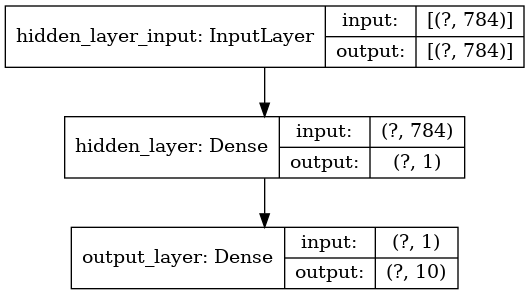

In [47]:
# SETUP
hidden_layer_units = 1

model = Sequential([
    Dense(name = "hidden_layer", units = hidden_layer_units, activation = tf.nn.relu, input_shape = (784,)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])
model.summary()

model.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

In [48]:
# TRAIN
history = model.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 10,
    validation_split=0.20 
    )

Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 2.0266 - accuracy: 0.1965 - val_loss: 1.9056 - val_accuracy: 0.2212
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.8777 - accuracy: 0.2264 - val_loss: 1.8412 - val_accuracy: 0.2382
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.8301 - accuracy: 0.2340 - val_loss: 1.8060 - val_accuracy: 0.2542
Epoch 4/10
1500/1500 [==============================] - 1s 973us/step - loss: 1.7854 - accuracy: 0.2609 - val_loss: 1.7480 - val_accuracy: 0.3179
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.7284 - accuracy: 0.3198 - val_loss: 1.7026 - val_accuracy: 0.3260
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.7033 - accuracy: 0.3225 - val_loss: 1.6882 - val_accuracy: 0.3276
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6934 - accuracy: 0.3285 - val_loss: 1.6797 - val_accurac

313/313 [==============================] - 0s 1ms/step - loss: 1.6905 - accuracy: 0.3451
test set accuracy:  34.50999855995178


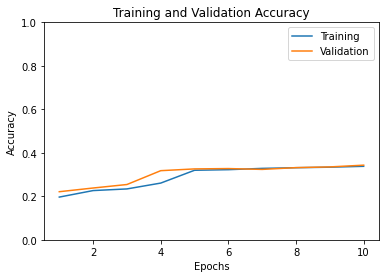

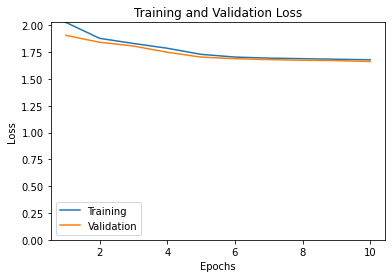

Confusion Mat


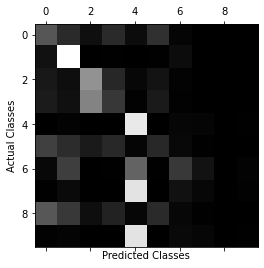

In [52]:
# TEST
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

# PERFORMANCE
history_dict = history.history
history_dict.keys()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# ACCURACY
plt.plot(range(1, len(acc) + 1), history.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history.history['val_accuracy'], label = 'Validation')
plt.ylim([0.0, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# LOSS
plt.plot(range(1, len(loss) + 1), history.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history.history['val_loss'], label = 'Validation')
plt.ylim([0.0, max(loss)])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# CONFUSION
pred_classes = np.argmax(model.predict(x_train_norm), axis=-1)
pred_classes
conf_mx = tf.math.confusion_matrix(y_train, pred_classes)
conf_mx

def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    

print("Confusion Mat")
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

There are 2 layers:
Tensor("hidden_layer/Relu_4:0", shape=(None, 1), dtype=float32)
Tensor("output_layer/Softmax_4:0", shape=(None, 10), dtype=float32)

Outputs of hidden nodes:
Hidden layer shape:
(60000, 1)

Output layer shape:
(60000, 10)

The maximum activation value of the hidden nodes in the hidden layer: 33.96721649169922


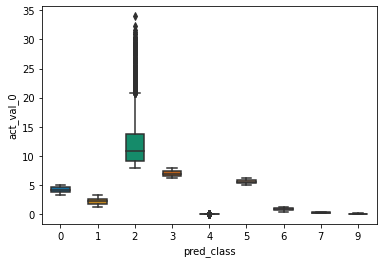

In [50]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers:")
for i in layer_outputs: print(i) # description of the layers

# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
print()
print('Outputs of hidden nodes:')
print('Hidden layer shape:')
print(hidden_layer_activation.shape)   #  each of the 128 hidden nodes has one activation value per training image
print()
print('Output layer shape:')
print(output_layer_activations.shape)

print()
print(f"The maximum activation value of the hidden nodes in the hidden layer: \
{hidden_layer_activation.max()}")

#Get the dataframe of all the node values
activation_data = {'pred_class':pred_classes}
for k in range(0,hidden_layer_units): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]


activation_df = pd.DataFrame(activation_data)
# To see how closely the hidden node activation values correlate with the class predictions
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='pred_class', 
                 data=activation_df[['act_val_0','pred_class']], 
                 width=0.5,
                 palette="colorblind")

# Results:
In experiment #1 a dense neural network consisting of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits) was trained. Activation values of the hidden node for the (original) set of training images by the 10 predicted classes were extracted and visualized using a boxplot. As expected, minimal overlap between the range of values in the "boxes" was noted. In addition, we find the pattern that maximally activates the hidden.